Note: Due to some constraint on computation memory, some of the code encountered "kernel died" when they were run again, so some of the plots didn't show up. The latter half of the code ran with only a few cells at a time and then with kernel restarted.

path: 

/xdisk/chanc/share/

there are two folders: GRMHD_dt1000M and GRMHD_dt10M

under GRMHD_dt1000M: Ma+0.5_w5  Ma+0.94_w5  Ma-0.5_w5  Ma-0.94_w5  Ma0_w5  Sa+0.5_w5  Sa+0.94_w5  Sa-0.5_w5  Sa-0.94_w5  Sa0_w5

under GRMHD_dt10M: Ma+0.94_w5  Ma-0.94_w5  Sa+0.94_w5, 5000 - 5999

### electron temperature:

eqn 27 of https://arxiv.org/pdf/2202.11721.pdf: $Te = \frac{m_{p}u(\gamma_{e}-1)(\gamma_{i}-1)}{k \rho (y(\gamma_{i}-1)+Rz(\gamma_{e}-1))}$ where: <br> y and z are the number of electrons and nucleons per unionized atom, respectively <br> eqn 22 $R = \frac{R_{low}}{1+\widetilde{\beta}^{2}}+ \frac{R_{high}\widetilde{\beta}^{2}}{1+\widetilde{\beta}^{2}}$ and $\widetilde{\beta} = \frac{\beta}{\beta_{crit}}$, assume $\beta_{crit}=1$. Try $R_{high}=1, 10, 40, 160$; $R_{low}=1$ <br> 

look for γ: https://arxiv.org/pdf/2202.11721.pdf <br> Assume ideal gas -> $Γ = \frac{5}{3} + \frac{4}{3}(1 - x_{e})$ where $x_{e}$ is the electron fraction. <br> $\gamma = \frac{4}{3}$, $x_{e} = \frac{1}{4}$, so ions:electrons = 3:1 (y=1, z=3; $\gamma_{i}=\gamma=\frac{4}{3}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{7}{3}$) <br> $\gamma = \frac{13}{9}$, $x_{e} = \frac{1}{3}$, so ions:electrons = 2:1 (y=1, z=2; $\gamma_{i}=\gamma=\frac{13}{9}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{133}{36}$) <br> $\gamma = \gamma_{i}=\frac{5}{3}$, so the gas is fully composed of ions (i.e. $\gamma_{e} = 0$) (? y=z=1; $\gamma_{i}=\gamma_{e} = \gamma = \frac{5}{3}$) <br>

For non-uniform $\gamma$: https://www.aanda.org/articles/aa/full_html/2015/08/aa26247-15/aa26247-15.html

We assume uniform $\gamma$ in the following simulations. <br>

Variance plot $(Te - <Te>)^{2}|_{calculated}$

In [1]:
from toolz import valmap

import h5py
import pyharm

from matplotlib   import pyplot as plt
import numpy as np
from pyharm.plots import plot_dumps as pplt

In [2]:
print(pyharm.units)

<module 'pyharm.units' from '/home/u12/limengjiang/.local/lib/python3.8/site-packages/pyharm/units.py'>


In [3]:
pyharm.units.get_cgs()

{'CL': 29979245800.0,
 'QE': 4.8032068e-10,
 'EE': 4.8032068e-10,
 'ME': 9.1093826e-28,
 'MP': 1.67262171e-24,
 'MN': 1.67492728e-24,
 'HPL': 6.6260693e-27,
 'HBAR': 1.0545717e-27,
 'KBOL': 1.3806505e-16,
 'GNEWT': 6.6742e-08,
 'SIG': 5.6704e-05,
 'AR': 7.5657e-15,
 'THOMSON': 6.65245873e-25,
 'JY': 1e-23,
 'PC': 3.085678e+18,
 'AU': 14959787069100.0,
 'MSOLAR': 1.989e+33,
 'RSOLAR': 69600000000.0,
 'LSOLAR': 3.827e+33}

In [4]:
i0 = 5990 # initial  frame
i1 = 6000 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [5]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [6]:
w = (-20,20,-20,20)
# are m and mm decided after a few attempts? yes
def mkplots(k, m, mm):
    # edge-on for xz
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    pplt.plot_xz(axes[0], dump0,      k, window=w, vmin=0, vmax=m)
    pplt.plot_xz(axes[1], dump1,      k, window=w, vmin=0, vmax=m)
    pplt.plot_xz(axes[2], dump, 'avg'+k, window=w, vmin=0, vmax=m)
    pplt.plot_xz(axes[3], dump, 'var'+k, window=w, vmin=0, vmax=mm)

In [7]:
def mkplots_td(k, m, mm):
    # top-down for xy
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    pplt.plot_xy(axes[0], dump0,      k, window=w2, vmin=0, vmax=m)
    pplt.plot_xy(axes[1], dump1,      k, window=w2, vmin=0, vmax=m)
    pplt.plot_xy(axes[2], dump, 'avg'+k, window=w2, vmin=0., vmax=m)
    pplt.plot_xy(axes[3], dump, 'var'+k, window=w2, vmin=0., vmax=mm)

## Electron Temperature Variance Plot(s)

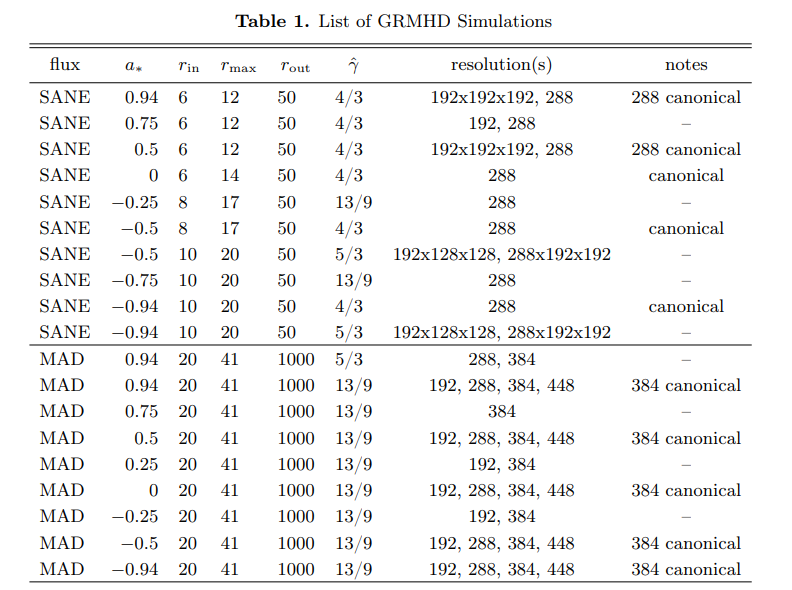

? $r_{max}$: the mkplot vmax value

### The! Units! In! GRMHD! Simulation! 

https://tok.fandom.com/wiki/Lorentz%E2%80%93Heaviside_units

https://academic.oup.com/mnras/article/454/2/1848/2892599

In [8]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16

In [9]:
# R
def R(dump, Rh, Rl):
    beta = dump['beta']
    return Rl/(1+beta**2)+Rh*beta**2/(1+beta**2)

In [10]:
# electron temperature
def Te(dump, Rh, Rl, gamma):
    if gamma == 4/3:
        y = 1
        z = 3
        gamma_i = 4/3
        gamma_e = 7/3
    if gamma == 13/9:
        y = 1
        z = 2
        gamma_i = 13/9
        gamma_e = 133/36
    if gamma == 5/3:
        y = 1
        z = 1
        gamma_i = 5/3
        gamma_e = 5/3
    beta = dump['beta']
    u = dump['Pg']/(gamma-1)
    r = R(dump, Rh, Rl)
    numerator = mp*cl**2*u*(gamma_e-1)*(gamma_i-1)
    denom = kb*dump['RHO']*(y*(gamma_i-1)+r*z*(gamma_e-1))
    Te = numerator/denom
    dump.cache['Te'] = Te
    return Te

In [11]:
i0 = 5000
i1 = 5010

src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

dump0 = pyharm.load_dump(fname(i0, src_ma_10M))
R_low = 1.
R_high = [1, 10, 40, 160]
# first row of SANE model params

In [12]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

In [13]:
def average(irange, keys, dumps):
    s = {'Te': np.zeros_like(dump0['Pg'])}
    for i in irange:
        print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        s['Te'] += d['Te'] 
    return valmap(lambda v: v/len(irange), s)

In [14]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps):
    ss = {'varTe': np.zeros_like(dump0['Pg'])}
    for i in irange:
        print(i)
        d = dumps[str(i)].cache
        ss['varTe'] += (d['Te']-d['avgTe'])**2
    return valmap(lambda v: v/len(irange), ss)

In [15]:
def change_Rh(i0, i1, src, idx, gamma=4/3):
    dumps = get_dumps(i0, i1, src)
    Te_rh = {} 
    dict_keys = dumps.keys()
    for key in dict_keys:
        temp = Te(dumps[key], R_high[idx], R_low, gamma)
        Te_rh[key] = temp
    dump0 = pyharm.load_dump(fname(i0, src))
    print('finish reading in dumps')
    Te_avg = average(range(i0, i1), ['Te'], dumps)
    for dump in dumps.values():
        dump.cache['avgTe'] = np.squeeze(np.array(list(Te_avg.values())))
    Te_var = variance(range(i0, i1), dumps)
    for dump in dumps.values():
        dump.cache['varTe'] = np.squeeze(np.array(list(Te_var.values())))
    return dumps

In [16]:
def MI(dumps, i0):
    dumps[str(i0)].cache['MI'] = np.sqrt(dumps[str(i0)].cache['varTe'])/dumps[str(i0)].cache['avgTe']

## $\gamma = \frac{4}{3}$

In [17]:
# try gamma = 4/3
# ahhhh unit conversion
# T_sa1 = Te(dump0, R_high[3], R_low, 4/3, 5000) 
# print(T_sa1)
# 10^4 K - 10^7K

In [18]:
# electron temperature, mad model, R_high = 1
dumps = get_dumps(5000, 5005, src_ma_10M)
Te_mad_rh1 = {} 
dict_keys = dumps.keys()
for key in dict_keys:
    Te_ma = Te(dumps[key], R_high[0], R_low, 4/3)
    Te_mad_rh1[key] = Te_ma

KeyboardInterrupt: 

In [19]:
dump0 = pyharm.load_dump(fname(5000, src_ma_10M))

In [20]:
# average
Te_Ma_avg1 = average(range(5000, 5005), ['Te'], dumps)
for dump in dumps.values():
    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Ma_avg1.values())))

i: 5000
i: 5001
i: 5002
i: 5003
i: 5004


In [21]:
print(dumps['5000'].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe'])


In [22]:
# variance
Te_Ma_var1 = variance(range(5000, 5005), dumps)
for dump in dumps.values():
    # if type(dump) is not str:
    dump.cache['varTe'] = np.squeeze(np.array(list(Te_Ma_var1.values())))

5000
5001
5002
5003
5004


In [23]:
print(dumps['5000'].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe', 'varTe'])


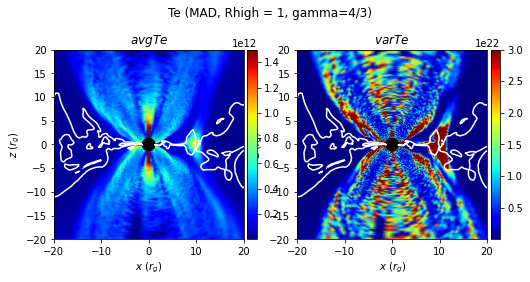

In [24]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(8,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps['5000'], 'avgTe', window=w, vmin=10**7, vmax=1.5*10**12)
pplt.plot_xz(axes[1], dumps['5000'], 'varTe', window=w, vmin=10**14, vmax=3.*10**22)
pplt.overlay_contours(axes[0], dumps['5000'], 'beta', (1.0,), color='white')
pplt.overlay_contours(axes[1], dumps['5000'], 'beta',(1.0,), color='white')
plt.suptitle('Te (MAD, Rhigh = 1, gamma=4/3)')
plt.show()

In [25]:
MI(dumps, 5000)

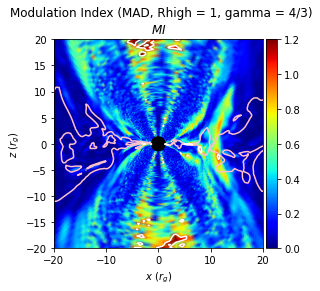

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps['5000'], 'MI', window=w, vmin=0., vmax=1.2)
plt.suptitle('Modulation Index (MAD, Rhigh = 1, gamma = 4/3)')
pplt.overlay_contours(ax, dumps['5000'], 'beta',(1.0,), color='pink')
# 1 σ away, i.e. MI > 1
pplt.overlay_contours(ax, dumps['5000'], 'MI',(1.0, 1.5), color='white')
plt.show()

In [17]:
# electron temperature, sane model, R_high = 1
dumps_sa = get_dumps(5000, 5005, src_sa_10M)
Te_sa_rh1 = {} 
dict_keys = dumps_sa.keys()
for key in dict_keys:
    Te_sa = Te(dumps_sa[key], R_high[0], R_low, 4/3)
    Te_sa_rh1[key] = Te_sa

In [18]:
print(dumps_sa.keys())
print(len(dumps_sa['5001'].cache))

dict_keys(['5000', '5001', '5002', '5003', '5004'])
10


In [19]:
dump0 = pyharm.load_dump(fname(5000, src_sa_10M))

In [20]:
# average
Te_Sa_avg1 = average(range(5000, 5005), ['Te'], dumps_sa)
for dump in dumps_sa.values():
    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Sa_avg1.values())))

i: 5000
i: 5001
i: 5002
i: 5003
i: 5004


In [21]:
print(dumps_sa['5000'].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe'])


In [22]:
# variance
Te_Sa_var1 = variance(range(5000, 5005), dumps_sa)
for dump in dumps_sa.values():
    # if type(dump) is not str:
    dump.cache['varTe'] = np.squeeze(np.array(list(Te_Sa_var1.values())))

5000
5001
5002
5003
5004


In [23]:
print(dumps_sa['5000'].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe', 'varTe'])


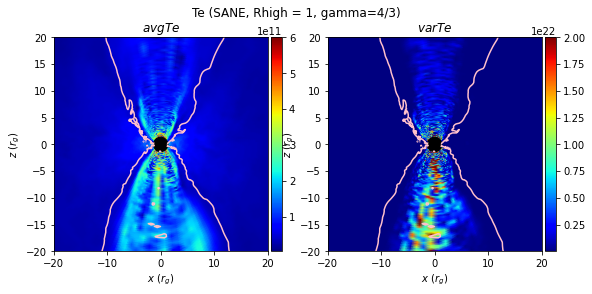

In [24]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa['5000'], 'avgTe', window=w, vmin=3*10**9, vmax=6.*10**11)
pplt.plot_xz(axes[1], dumps_sa['5000'], 'varTe', window=w, vmin=5*10**12, vmax=2.*10**22)
pplt.overlay_contours(axes[0], dumps_sa['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 1, gamma=4/3)')
plt.show()

In [25]:
MI(dumps_sa, 5000)

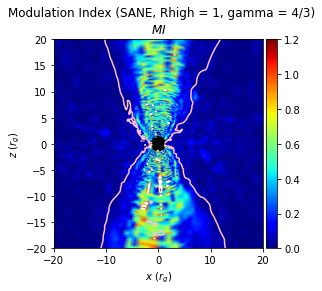

In [26]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa['5000'], 'MI', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(ax, dumps_sa['5000'], 'beta',(1.0,), color='pink')
# 1σ and above
pplt.overlay_contours(ax, dumps_sa['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 1, gamma = 4/3)')
plt.show()

In [17]:
# MAD, R_h = 10
dumps_rh10 = change_Rh(5000, 5005, src_ma_10M, 1)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


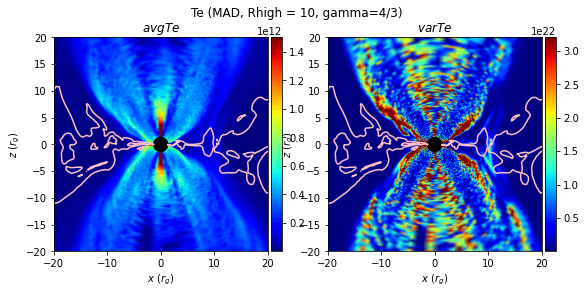

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh10['5000'], 'avgTe', window=w, vmin=10**7, vmax=1.5*10**12)
pplt.plot_xz(axes[1], dumps_rh10['5000'], 'varTe', window=w, vmin=10**13, vmax=3.2*10**22)
pplt.overlay_contours(axes[0], dumps_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh10['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 10, gamma=4/3)')
plt.show()

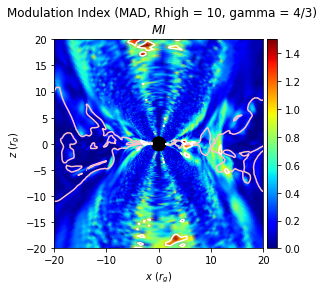

In [23]:
MI(dumps_rh10, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh10['5000'], 'MI', window=w, vmin=0., vmax=1.5)
pplt.overlay_contours(ax, dumps_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh10['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 10, gamma = 4/3)')
plt.show()

In [17]:
# SANE, R_h = 10 (idx=1)
dumps_sa_rh10 = change_Rh(5000, 5005, src_sa_10M, 1)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


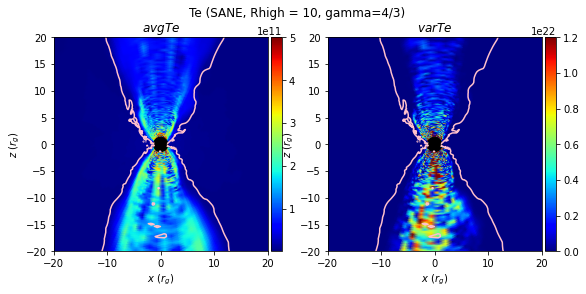

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh10['5000'], 'avgTe', window=w, vmin=10**6, vmax=5.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh10['5000'], 'varTe', window=w, vmin=10**12, vmax=1.2*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 10, gamma=4/3)')
plt.show()

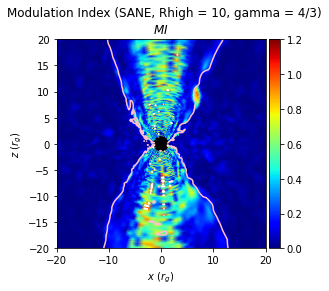

In [21]:
MI(dumps_sa_rh10, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh10['5000'], 'MI', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(ax, dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh10['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 10, gamma = 4/3)')
plt.show()

In [17]:
# MAD, R_h = 40
dumps_rh40 = change_Rh(5000, 5005, src_ma_10M, 2)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


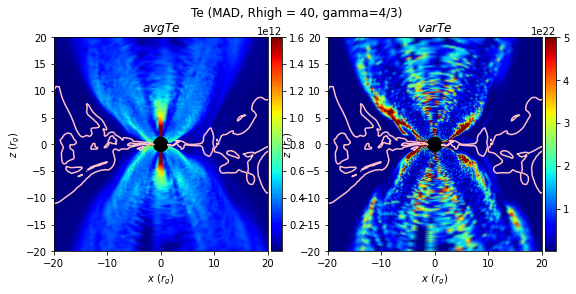

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh40['5000'], 'avgTe', window=w, vmin=10**7, vmax=1.6*10**12)
pplt.plot_xz(axes[1], dumps_rh40['5000'], 'varTe', window=w, vmin=10**13, vmax=5.*10**22)
pplt.overlay_contours(axes[0], dumps_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh40['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 40, gamma=4/3)')
plt.show()

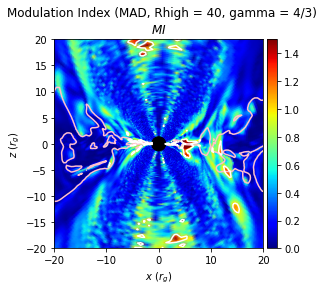

In [19]:
MI(dumps_rh40, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh40['5000'], 'MI', window=w, vmin=0., vmax=1.5)
pplt.overlay_contours(ax, dumps_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh40['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 40, gamma = 4/3)')
plt.show()

In [17]:
# SANE, R_h = 40 (idx=2)
dumps_sa_rh40 = change_Rh(5000, 5005, src_sa_10M, 2)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh40['5000'], 'avgTe', window=w, vmin=10**6, vmax=5.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh40['5000'], 'varTe', window=w, vmin=10**12, vmax=1.5*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 40, gamma=4/3)')
plt.show()

In [19]:
# ? why there's a region where MI > 1 and outside β=1
MI(dumps_sa_rh40, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh40['5000'], 'MI', window=w, vmin=0., vmax=1.3)
pplt.overlay_contours(ax, dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh40['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 40, gamma = 4/3)')
plt.show()

In [17]:
# MAD, R_h = 160
dumps_rh160 = change_Rh(5000, 5005, src_ma_10M, 3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


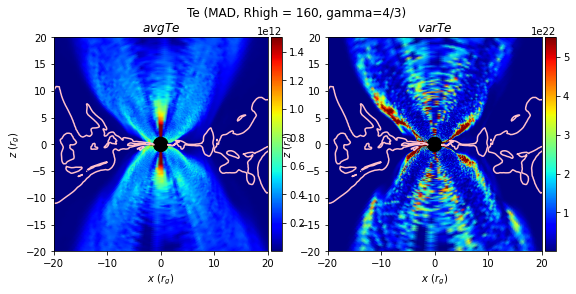

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh160['5000'], 'avgTe', window=w, vmin=10**7, vmax=1.5*10**12)
pplt.plot_xz(axes[1], dumps_rh160['5000'], 'varTe', window=w, vmin=10**13, vmax=5.5*10**22)
pplt.overlay_contours(axes[0], dumps_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh160['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 160, gamma=4/3)')
plt.show()

In [19]:
MI(dumps_rh160, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh160['5000'], 'MI', window=w, vmin=0., vmax=1.75)
pplt.overlay_contours(ax, dumps_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh160['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 160, gamma = 4/3)')
plt.show()

In [17]:
# SANE, R_h = 160 (idx=3)
dumps_sa_rh160 = change_Rh(5000, 5005, src_sa_10M, 3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


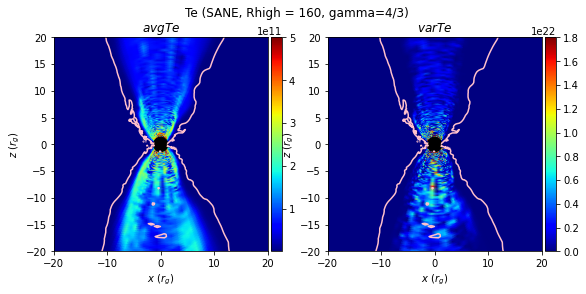

In [19]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh160['5000'], 'avgTe', window=w, vmin=10**6, vmax=5.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh160['5000'], 'varTe', window=w, vmin=10**11, vmax=1.8*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 160, gamma=4/3)')
plt.show()

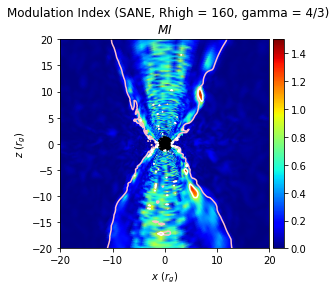

In [20]:
MI(dumps_sa_rh160, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh160['5000'], 'MI', window=w, vmin=0., vmax=1.5)
pplt.overlay_contours(ax, dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh160['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 160, gamma = 4/3)')
plt.show()

## $\gamma = \frac{5}{3}$

In [17]:
# MAD, R_h = 1
dumps_rh1 = change_Rh(5000, 5005, src_ma_10M, 0, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh1['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.*10**12)
pplt.plot_xz(axes[1], dumps_rh1['5000'], 'varTe', window=w, vmin=10**13, vmax=1.*10**23)
pplt.overlay_contours(axes[0], dumps_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh1['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 1, gamma=5/3)')
plt.show()

In [19]:
MI(dumps_rh1, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh1['5000'], 'MI', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(ax, dumps_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh1['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 1, gamma = 5/3)')
plt.show()

In [17]:
# SANE, R_h = 1 (idx=0)
dumps_sa_rh1 = change_Rh(5000, 5005, src_sa_10M, 0, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh1['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=6.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh1['5000'], 'varTe', window=w, vmin=2*10**12, vmax=3.*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh1['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 1, gamma=5/3)')
plt.show()

In [21]:
MI(dumps_sa_rh1, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh1['5000'], 'MI', window=w, vmin=0., vmax=1.1)
pplt.overlay_contours(ax, dumps_sa_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh1['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 1, gamma = 5/3)')
plt.show()

In [17]:
# MAD, R_h = 10
dumps_rh10 = change_Rh(5000, 5005, src_ma_10M, 1, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


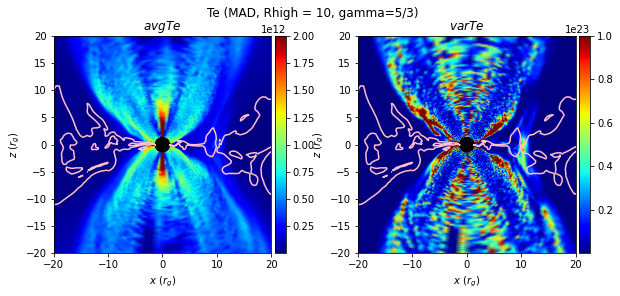

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh10['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.*10**12)
pplt.plot_xz(axes[1], dumps_rh10['5000'], 'varTe', window=w, vmin=10**13, vmax=1.*10**23)
pplt.overlay_contours(axes[0], dumps_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh10['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 10, gamma=5/3)')
plt.show()

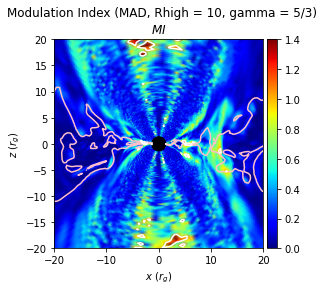

In [19]:
MI(dumps_rh10, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh10['5000'], 'MI', window=w, vmin=0., vmax=1.4)
pplt.overlay_contours(ax, dumps_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh10['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 10, gamma = 5/3)')
plt.show()

In [17]:
# SANE, R_h = 10 (idx=1)
dumps_sa_rh10 = change_Rh(5000, 5005, src_sa_10M, 1, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


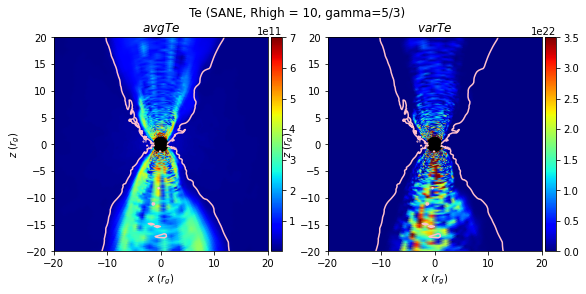

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh10['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=7.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh10['5000'], 'varTe', window=w, vmin=2*10**12, vmax=3.5*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 10, gamma=5/3)')
plt.show()

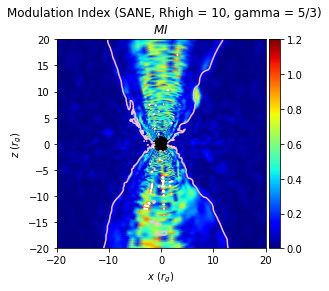

In [19]:
MI(dumps_sa_rh10, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh10['5000'], 'MI', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(ax, dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh10['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 10, gamma = 5/3)')
plt.show()

In [17]:
# MAD, R_h = 40
dumps_rh40 = change_Rh(5000, 5005, src_ma_10M, 2, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


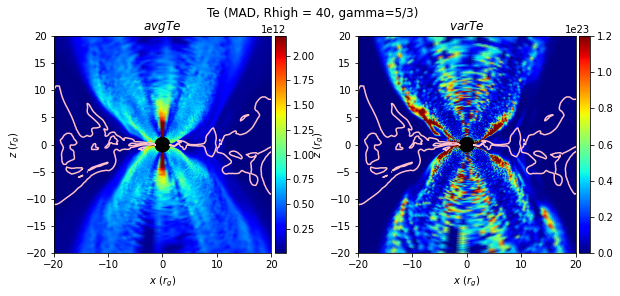

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh40['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.2*10**12)
pplt.plot_xz(axes[1], dumps_rh40['5000'], 'varTe', window=w, vmin=10**13, vmax=1.2*10**23)
pplt.overlay_contours(axes[0], dumps_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh40['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 40, gamma=5/3)')
plt.show()

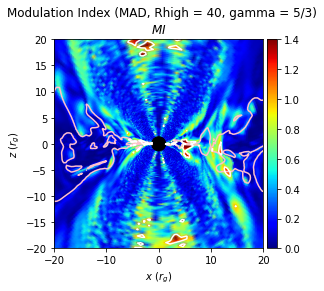

In [19]:
MI(dumps_rh40, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh40['5000'], 'MI', window=w, vmin=0., vmax=1.4)
pplt.overlay_contours(ax, dumps_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh40['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 40, gamma = 5/3)')
plt.show()

In [17]:
# SANE, R_h = 40 (idx=2)
dumps_sa_rh40 = change_Rh(5000, 5005, src_sa_10M, 2, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


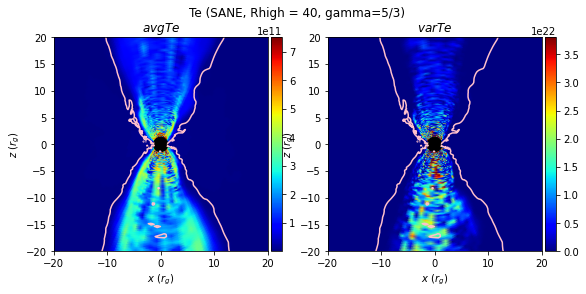

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
pplt.plot_xz(axes[0], dumps_sa_rh40['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=7.5*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh40['5000'], 'varTe', window=w, vmin=2*10**12, vmax=3.8*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 40, gamma=5/3)')
plt.show()

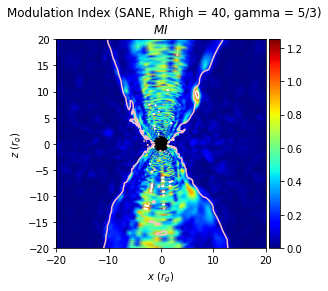

In [19]:
MI(dumps_sa_rh40, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh40['5000'], 'MI', window=w, vmin=0., vmax=1.25)
pplt.overlay_contours(ax, dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh40['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 40, gamma = 5/3)')
plt.show()

In [17]:
# MAD, R_h = 160
dumps_rh160 = change_Rh(5000, 5005, src_ma_10M, 3, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


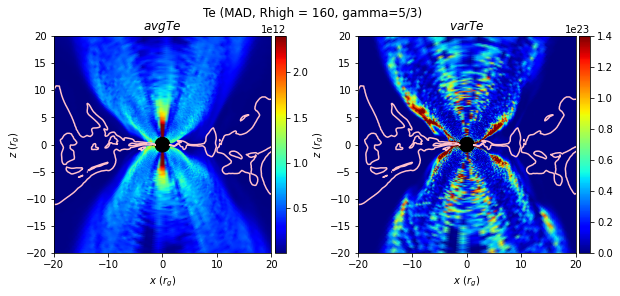

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh160['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.4*10**12)
pplt.plot_xz(axes[1], dumps_rh160['5000'], 'varTe', window=w, vmin=8*10**12, vmax=1.4*10**23)
pplt.overlay_contours(axes[0], dumps_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh160['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 160, gamma=5/3)')
plt.show()

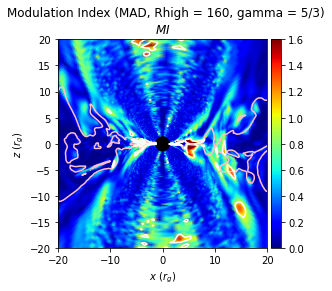

In [19]:
MI(dumps_rh160, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh160['5000'], 'MI', window=w, vmin=0., vmax=1.6)
pplt.overlay_contours(ax, dumps_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh160['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 160, gamma = 5/3)')
plt.show()

In [17]:
# SANE, R_h = 160 (idx=3)
dumps_sa_rh160 = change_Rh(5000, 5005, src_sa_10M, 3, 5/3)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


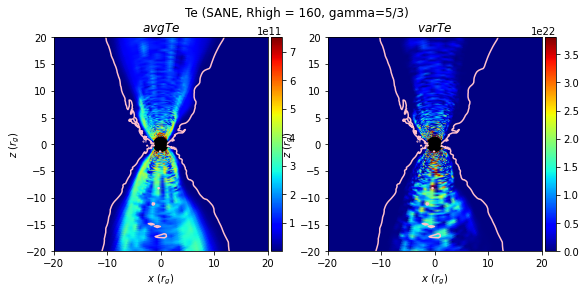

In [18]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
pplt.plot_xz(axes[0], dumps_sa_rh160['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=7.5*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh160['5000'], 'varTe', window=w, vmin=2*10**12, vmax=3.8*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 160, gamma=5/3)')
plt.show()

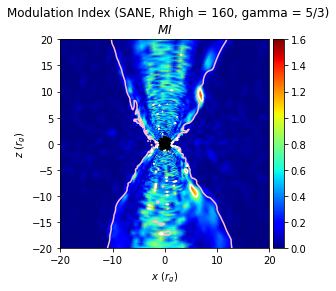

In [19]:
MI(dumps_sa_rh160, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh160['5000'], 'MI', window=w, vmin=0., vmax=1.6)
pplt.overlay_contours(ax, dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh160['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 160, gamma = 5/3)')
plt.show()

## $\gamma = \frac{13}{9}$

In [17]:
# MAD, R_h = 1
dumps_rh1 = change_Rh(5000, 5005, src_ma_10M, 0, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


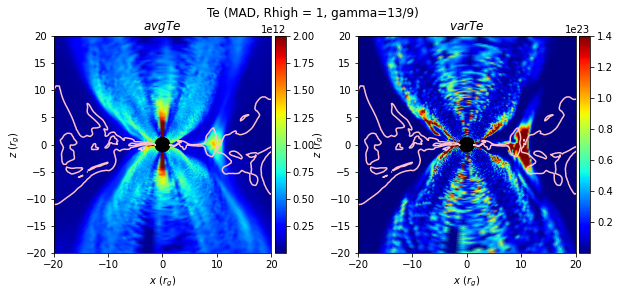

In [23]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh1['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.*10**12)
pplt.plot_xz(axes[1], dumps_rh1['5000'], 'varTe', window=w, vmin=8*10**13, vmax=1.4*10**23)
pplt.overlay_contours(axes[0], dumps_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh1['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 1, gamma=13/9)')
plt.show()

In [24]:
MI(dumps_rh1, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh1['5000'], 'MI', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(ax, dumps_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh1['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 1, gamma = 13/9)')
plt.show()

In [17]:
# SANE, R_h = 1 (idx=0)
dumps_sa_rh1 = change_Rh(5000, 5005, src_sa_10M, 0, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


In [20]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh1['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=6.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh1['5000'], 'varTe', window=w, vmin=2.5*10**12, vmax=3.*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh1['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 1, gamma=13/9)')
plt.show()

In [21]:
MI(dumps_sa_rh1, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh1['5000'], 'MI', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(ax, dumps_sa_rh1['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh1['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 1, gamma = 13/9)')
plt.show()

In [17]:
# MAD, R_h = 10
dumps_rh10 = change_Rh(5000, 5005, src_ma_10M, 1, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


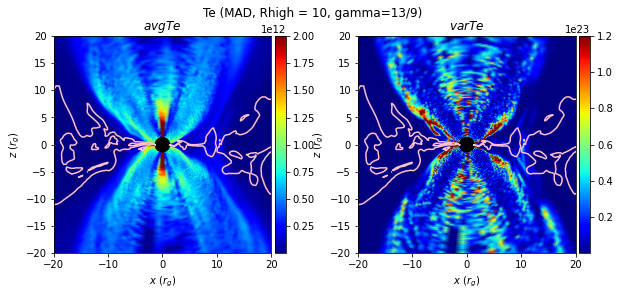

In [21]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh10['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.*10**12)
pplt.plot_xz(axes[1], dumps_rh10['5000'], 'varTe', window=w, vmin=1.2*10**13, vmax=1.2*10**23)
pplt.overlay_contours(axes[0], dumps_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh10['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 10, gamma=13/9)')
plt.show()

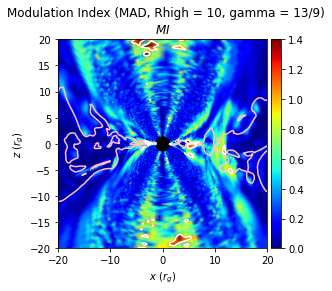

In [22]:
MI(dumps_rh10, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh10['5000'], 'MI', window=w, vmin=0., vmax=1.4)
pplt.overlay_contours(ax, dumps_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh10['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 10, gamma = 13/9)')
plt.show()

In [17]:
# SANE, R_h = 10 (idx=1)
dumps_sa_rh10 = change_Rh(5000, 5005, src_sa_10M, 1, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


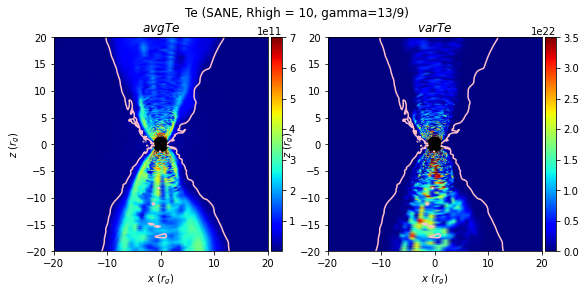

In [20]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps['5000'].cache.values = list(dumps['5000'].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh10['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=7.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh10['5000'], 'varTe', window=w, vmin=2.5*10**12, vmax=3.5*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 10, gamma=13/9)')
plt.show()

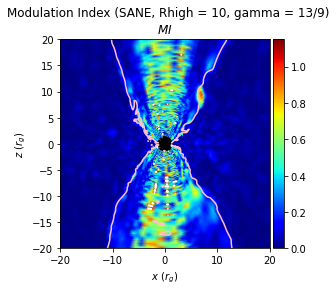

In [22]:
MI(dumps_sa_rh10, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh10['5000'], 'MI', window=w, vmin=0., vmax=1.15)
pplt.overlay_contours(ax, dumps_sa_rh10['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh10['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 10, gamma = 13/9)')
plt.show()

In [17]:
# MAD, R_h = 40
dumps_rh40 = change_Rh(5000, 5005, src_ma_10M, 2, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


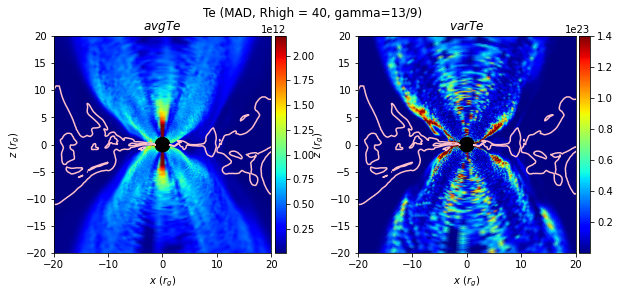

In [20]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh40['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.2*10**12)
pplt.plot_xz(axes[1], dumps_rh40['5000'], 'varTe', window=w, vmin=1.4*10**13, vmax=1.4*10**23)
pplt.overlay_contours(axes[0], dumps_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh40['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 40, gamma=13/9)')
plt.show()

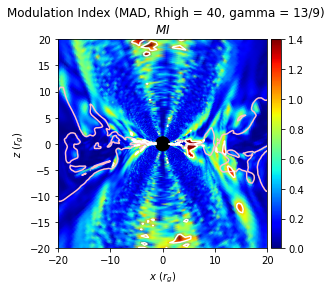

In [21]:
MI(dumps_rh40, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh40['5000'], 'MI', window=w, vmin=0., vmax=1.4)
pplt.overlay_contours(ax, dumps_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh40['5000'], 'MI',[1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 40, gamma = 13/9)')
plt.show()

In [17]:
# SANE, R_h = 40 (idx=2)
dumps_sa_rh40 = change_Rh(5000, 5005, src_sa_10M, 2, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


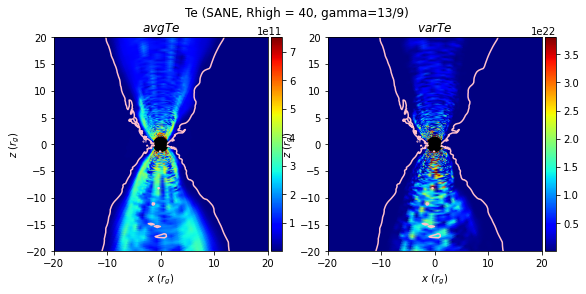

In [23]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
pplt.plot_xz(axes[0], dumps_sa_rh40['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=7.5*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh40['5000'], 'varTe', window=w, vmin=4.*10**12, vmax=3.8*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 40, gamma=13/9)')
plt.show()

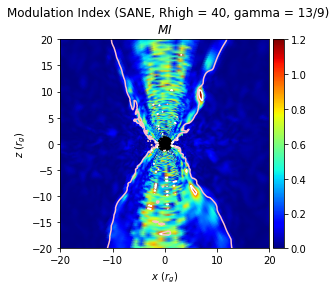

In [25]:
MI(dumps_sa_rh40, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh40['5000'], 'MI', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(ax, dumps_sa_rh40['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh40['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 40, gamma = 13/9)')
plt.show()

In [17]:
# MAD, R_h = 160
dumps_rh160 = change_Rh(5000, 5005, src_ma_10M, 3, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


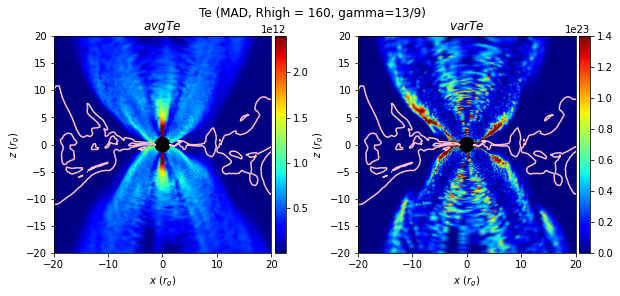

In [20]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(10,4))
pplt.plot_xz(axes[0], dumps_rh160['5000'], 'avgTe', window=w, vmin=10**7, vmax=2.4*10**12)
pplt.plot_xz(axes[1], dumps_rh160['5000'], 'varTe', window=w, vmin=8*10**12, vmax=1.4*10**23)
pplt.overlay_contours(axes[0], dumps_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh160['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (MAD, Rhigh = 160, gamma=13/9)')
plt.show()

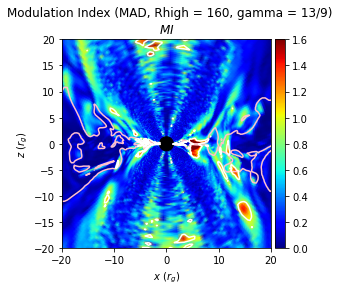

In [21]:
MI(dumps_rh160, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_rh160['5000'], 'MI', window=w, vmin=0., vmax=1.6)
pplt.overlay_contours(ax, dumps_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_rh160['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (MAD, Rhigh = 160, gamma = 13/9)')
plt.show()

In [19]:
# SANE, R_h = 160 (idx=3)
dumps_sa_rh160 = change_Rh(5000, 5005, src_sa_10M, 3, 13/9)

finish reading in dumps
i: 5000
i: 5001
i: 5002
i: 5003
i: 5004
5000
5001
5002
5003
5004


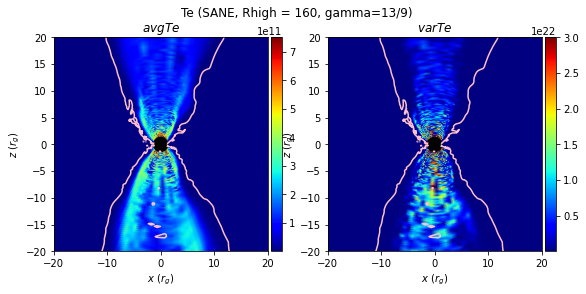

In [22]:
w = (-20,20,-20,20)
fig, axes = plt.subplots(1,2, figsize=(9,4))
pplt.plot_xz(axes[0], dumps_sa_rh160['5000'], 'avgTe', window=w, vmin=2*10**6, vmax=7.5*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh160['5000'], 'varTe', window=w, vmin=4*10**12, vmax=3.*10**22)
pplt.overlay_contours(axes[0], dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
plt.suptitle('Te (SANE, Rhigh = 160, gamma=13/9)')
plt.show()

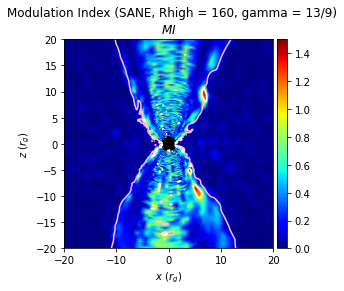

In [25]:
MI(dumps_sa_rh160, i0)
fig, ax = plt.subplots(1,1, figsize=(4,4))
pplt.plot_xz(ax, dumps_sa_rh160['5000'], 'MI', window=w, vmin=0., vmax=1.5)
pplt.overlay_contours(ax, dumps_sa_rh160['5000'], 'beta',(1.0,), color='pink')
pplt.overlay_contours(ax, dumps_sa_rh160['5000'], 'MI', [1.0,], color='white')
plt.suptitle('Modulation Index (SANE, Rhigh = 160, gamma = 13/9)')
plt.show()